In [0]:
import os
!rm -rf *
!rm -rf .kaggle/
!git clone https://github.com/bkahn-github/data-science-bowl.git
!pip install -r data-science-bowl/requirements.txt
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install Pillow
!mkdir ~/.kaggle
f = open(".kaggle/kaggle.json", "w")
f.write('{"username":"bkkaggle","key":"bf4e62680116284087ace0484990f87a"}')
f.close()
!kaggle competitions download -c data-science-bowl-2018
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train.zip -d ~/.kaggle/competitions/data-science-bowl-2018/train
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_test.zip -d ~/.kaggle/competitions/data-science-bowl-2018/test
!unzip ~/.kaggle/competitions/data-science-bowl-2018/stage1_train_labels.csv.zip -d ~/.kaggle/competitions/data-science-bowl-2018/labels
os.chdir('data-science-bowl/pytorchUnet')
!git checkout new-pytorch-unet

In [0]:
os.chdir('../../')
!rm -rf data-science-bowl/
!git clone https://github.com/bkahn-github/data-science-bowl.git
os.chdir('data-science-bowl/pytorchUnet')
!git checkout new-pytorch-unet

In [0]:
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch.backends import cudnn

from tqdm import tqdm, tqdm_notebook

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

%matplotlib inline

from load_data import load_data
from metrics import dice_loss, iou
from model import UNet
from process_data import predict, encode, upsample
from visualize import show_val, show_test
from submit import submit

In [3]:
train, val, x_test_sizes, train_dataset, val_dataset, test_dataset, train_dataloader, val_dataloader, test_dataloader = load_data()

100%|██████████| 65/65 [00:00<00:00, 145.84it/s]


In [23]:
model = UNet(3, 1).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for epoch in range(10):
  train_ious = []
  val_ious = []

  for x_train, y_train in tqdm(train_dataloader):
    x_train = Variable(x_train).cuda()
    y_train = Variable(y_train).cuda()

    optimizer.zero_grad()

    outputs = model(x_train)

    loss = dice_loss(outputs, y_train)
    train_iou, _ = iou((outputs.cpu().data.squeeze(0).numpy() > 0.5), y_train.cpu().data.numpy())
    train_ious.append(train_iou)

    loss.backward()
    optimizer.step()

  for x_val, y_val in tqdm(val_dataloader):
    x_val = Variable(x_val).cuda()
    y_val = Variable(y_val).cuda()

    optimizer.zero_grad()

    o = model(x_val)

    val_loss = dice_loss(o, y_val)
    val_iou, _ = iou((o.cpu().data.squeeze(0).numpy() > 0.5), y_val.cpu().data.numpy())
    val_ious.append(val_iou)

  print('\n')
  print(f'Epoch: {epoch + 1} Training IOU: {np.asarray(train_ious).mean()} Val IOU: {np.asarray(val_ious).mean()} Training Loss: {round(loss.data[0], 4)} Val Loss: {round(val_loss.data[0], 4)}', end='\n')


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 1 Training IOU: 0.013432835820895524 Val IOU: 0.023529411764705882 Training Loss: 0.6216 Val Loss: 0.7238


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 2 Training IOU: 0.06417910447761194 Val IOU: 0.06470588235294118 Training Loss: 0.5484 Val Loss: 0.6564


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 3 Training IOU: 0.10746268656716418 Val IOU: 0.12941176470588237 Training Loss: 0.5459 Val Loss: 0.6307


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 4 Training IOU: 0.15000000000000002 Val IOU: 0.14705882352941177 Training Loss: 0.4405 Val Loss: 0.6023


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 5 Training IOU: 0.2074626865671642 Val IOU: 0.2088235294117647 Training Loss: 0.4239 Val Loss: 0.5721


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 6 Training IOU: 0.22164179104477613 Val IOU: 0.24117647058823527 Training Loss: 0.3401 Val Loss: 0.5502


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 7 Training IOU: 0.24925373134328357 Val IOU: 0.24117647058823527 Training Loss: 0.3507 Val Loss: 0.5519


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 8 Training IOU: 0.2776119402985075 Val IOU: 0.25882352941176473 Training Loss: 0.339 Val Loss: 0.5112


  0%|          | 0/134 [00:00<?, ?it/s]



Epoch: 9 Training IOU: 0.30970149253731344 Val IOU: 0.3176470588235294 Training Loss: 0.2925 Val Loss: 0.4971


100%|██████████| 34/34 [00:02<00:00, 11.66it/s]



Epoch: 10 Training IOU: 0.36492537313432827 Val IOU: 0.3764705882352941 Training Loss: 0.2398 Val Loss: 0.4731


0.5


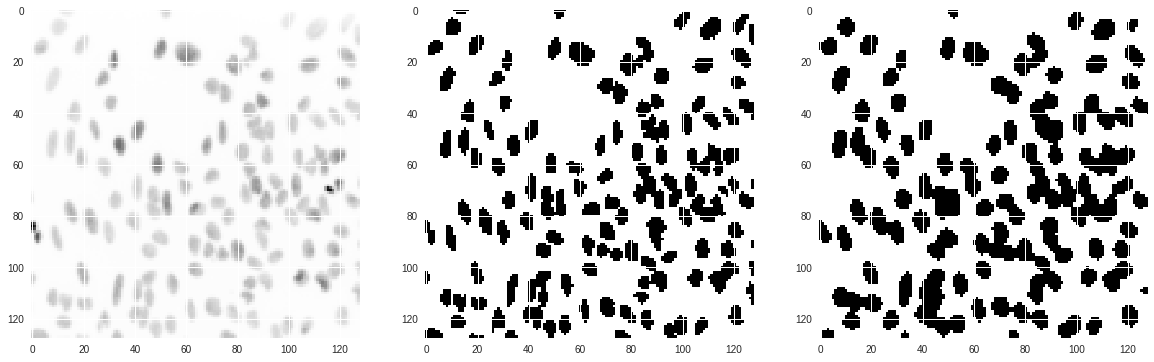

In [14]:
show_val(1, model, iou, val_dataset)

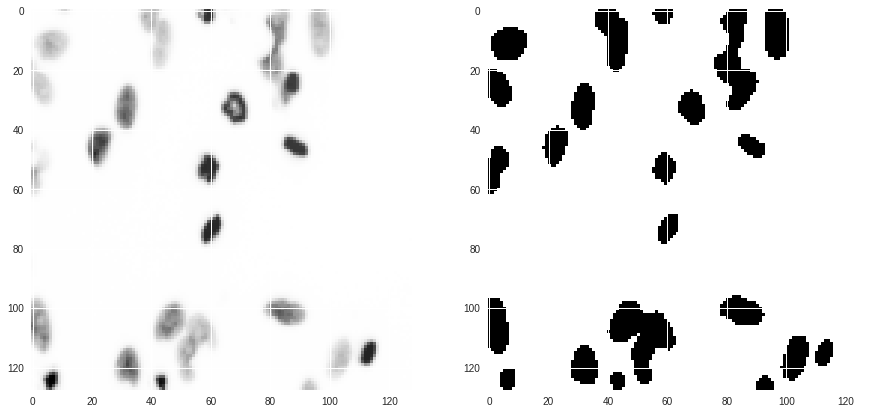

In [15]:
show_test(1, model, test_dataset)

In [16]:
preds = predict(model, test_dataset, test_dataloader, optimizer)

65it [00:01, 42.55it/s]


In [0]:
preds_upsampled = upsample(preds)

In [0]:
test_path = '../../.kaggle/competitions/data-science-bowl-2018/test/'
test_ids = next(os.walk(test_path))[1]

rles, new_test_ids = encode(preds_upsampled, test_ids)

In [0]:
submit(new_test_ids, rles)

In [0]:
pd.read_csv('./submission.csv')

In [0]:
from google.colab import files

files.download('submission.csv')